In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [3]:
import easydict
import json

args = easydict.EasyDict()
args.default_path = '/content/data/MyDrive/google_lecture/06. deep learning/4. RS Pytorch/data/Movie/ml-1m/'
args.ratings = args.default_path+'ratings.csv'
args.movies_metadata = args.default_path+'movies_metadata.csv'

# Model V1 with Word2Vec

## Load Data

In [4]:
import pandas as pd
import numpy as np

In [15]:
movie = pd.read_csv(args.ratings, low_memory=False)
movie.head(2)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


In [16]:
movie = movie.sort_values(by='timestamp', ascending=True).reset_index(drop=True)
movie.head(2)

,userId,movieId,rating,timestamp
0,383,21,3.0,789652009
1,383,47,5.0,789652009


영화의 Metadata를 불러와서 movieID에 맞는 TITLE을 구해줍니다. 

In [17]:
meta = pd.read_csv(args.movies_metadata, low_memory=False)
meta.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [18]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [19]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


## Join movie & meta

In [20]:
meta = meta.rename(columns={'id':'movieId'}) # movie_id
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], how='left', on='movieId')

movie.head(2)

,userId,movieId,rating,timestamp,original_title
0,383,21,3.0,789652009,The Endless Summer
1,383,47,5.0,789652009,NaN


## 결측치 제거 

In [21]:
(movie.isnull().sum() / movie.shape[0]).round(4).sort_values(ascending=False) # 각 걸럼별 결측치 비율

original_title    0.5501
userId            0.0000
movieId           0.0000
rating            0.0000
timestamp         0.0000
dtype: float64

In [22]:
movie = movie[movie['original_title'].notnull()].reset_index(drop=True)

(movie.isnull().sum() / movie.shape[0]).round(4).sort_values(ascending=False) # 각 걸럼별 결측치 비율

userId            0.0
movieId           0.0
rating            0.0
timestamp         0.0
original_title    0.0
dtype: float64

## 사용자별 시청 영화

In [23]:
agg = movie.groupby(['userId'])['original_title'].agg({'unique'})

print(agg.shape)
agg.head() # 사용자별 시청 영화 

(671, 1)


,unique
userId,
1,"[Jay and Silent Bob Strike Back, Vivement dima..."
2,"[Terminator 3: Rise of the Machines, The Conve..."
3,"[300, The Killing, Shortbus, Finding Neverland..."
4,"[David, The Wedding Planner, Casablanca, Sleep..."
5,"[Gleaming the Cube, Cool Hand Luke, Hidalgo, U..."


In [24]:
sentence = []
for user_sentence in agg['unique'].values:
    sentence.append(list(user_sentence))
    # sentence.append(list(map(str, user_sentence)))
len(sentence)

671

In [ ]:
sentence[:2]

[['Jay and Silent Bob Strike Back',
  'Vivement dimanche!',
  'Rocky III',
  'American Pie',
  'My Tutor',
  'Greed'],
 ['Terminator 3: Rise of the Machines',
  'The Conversation',
  'The Hours',
  '48 Hrs.',
  'Back to the Future Part II',
  'Silent Hill',
  'Crustacés et coquillages',
  'Lost in Translation',
  'Night on Earth',
  "Dave Chappelle's Block Party",
  "Ocean's Eleven",
  'Sissi',
  'Live and Let Die',
  'A Clockwork Orange',
  'Солярис',
  'Sommer vorm Balkon',
  'La science des rêves',
  'Trois couleurs : Rouge',
  'Grbavica',
  'Czlowiek z zelaza',
  'Le Mépris',
  'Batman Returns',
  'Romeo + Juliet',
  'Monsoon Wedding',
  'Stand by Me',
  'Lucky Number Slevin',
  'Cat on a Hot Tin Roof',
  'The Dark',
  'The Devil Wears Prada',
  'Lili Marleen',
  'Star Trek IV: The Voyage Home',
  'A Nightmare on Elm Street',
  'Notting Hill',
  'Once Were Warriors',
  'Reservoir Dogs',
  '2001: A Space Odyssey',
  'Rebecca',
  'Psycho',
  'The Poseidon Adventure',
  'Batman Begins

## [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html)
- https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial#Final-Thoughts


input params
- window (int, optional) – Maximum distance between the current and predicted word within a sentence.
  > 주변을 몇 칸까지 볼지에 대한 크기

- min_count (int, optional) – Ignores all words with total frequency lower than this.
- workers (int, optional) – Use these many worker threads to train the model (=faster training with multicore machines
- sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW.

### 모델 학습

In [25]:
# Word2vec의 학습을 진행해줍니다. 
from gensim.models import Word2Vec

embedding_model = Word2Vec(sentence, window = 5, 
                          min_count=1, workers=4, sg=1)

## 추천

In [26]:
embedding_model.wv.most_similar(positive=['Spider-Man 2'], topn=10)

[('The Life Aquatic with Steve Zissou', 0.9975979328155518),
 ('Erkan & Stefan gegen die Mächte der Finsternis', 0.9971785545349121),
 ('Crime of Passion', 0.9969322085380554),
 ("La Marche de l'empereur", 0.9966831803321838),
 ('Poodle Springs', 0.9965593814849854),
 ('Secret Window', 0.9965054392814636),
 ('Rent', 0.99639493227005),
 ('Laitakaupungin valot', 0.9956087470054626),
 ('Bird on a Wire', 0.9955077171325684),
 ('Topaz', 0.9954679012298584)]

# Model V2 with Doc2Vec

## Load Data

In [27]:
import pandas as pd 

In [28]:
movie = pd.read_csv(args.ratings, low_memory=False)
movie.head(2)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


In [29]:
meta = pd.read_csv(args.movies_metadata, low_memory=False)
meta.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


## 결측치 제거

In [30]:
meta = meta[meta['original_title'].notnull()].reset_index(drop=True)
meta = meta[meta['overview'].notnull()].reset_index(drop=True)

## Token

In [31]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [32]:
from nltk.corpus import stopwords 
from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize, sent_tokenize
import re 

stop_words = set(stopwords.words('english')) 

len(stop_words), list(stop_words)[:3]

(179, ['on', "you'd", 'doing'])

In [33]:
overview = []

for words in tqdm(meta['overview']):
    # cleaning 
    sentence = re.sub('[^A-Za-z0-9]+', ' ', str(words)) # 영어와 숫자이외에는 제거
    sentence = sentence.strip() # 빈칸 제거 
    sentence = sentence.lower() # 소문자로 변환 

    # tokenize
    sentence_tokens = word_tokenize(sentence)

    # stop_words
    result = ''
    for token in sentence_tokens: 
        if token not in stop_words: # stop words 제거 
            result += ' ' + token 
    overview.append(result)

  0%|          | 0/44512 [00:00<?, ?it/s]

In [34]:
overview[:2]

[' led woody andy toys live happily room andy birthday brings buzz lightyear onto scene afraid losing place andy heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences',
 ' siblings judy peter discover enchanted board game opens door magical world unwittingly invite alan adult trapped inside game 26 years living room alan hope freedom finish game proves risky three find running giant rhinoceroses evil monkeys terrifying creatures']

In [35]:
def add_pre_overview(overview):
    # cleaning 
    sentence = re.sub('[^A-Za-z0-9]+', ' ', str(overview)) # 영어와 숫자이외에는 제거
    sentence = sentence.strip() # 빈칸 제거 
    sentence = sentence.lower() # 소문자로 변환 

    # tokenize
    sentence_tokens = word_tokenize(sentence)

    # stop_words
    result = ''
    for token in sentence_tokens: 
        if token not in stop_words: # stop words 제거 
            result += ' ' + token 

    return result

In [36]:
meta['pre_overview'] = meta['overview'].map(lambda x: add_pre_overview(x))
meta.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,pre_overview
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,led woody andy toys live happily room andy bi...
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,siblings judy peter discover enchanted board ...


## [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html)
Word2Vec은 단어에 대한 vector를 생성한다면, Doc2Vec은 문장/문단/문서의 단위로 vector를 생성합니다.

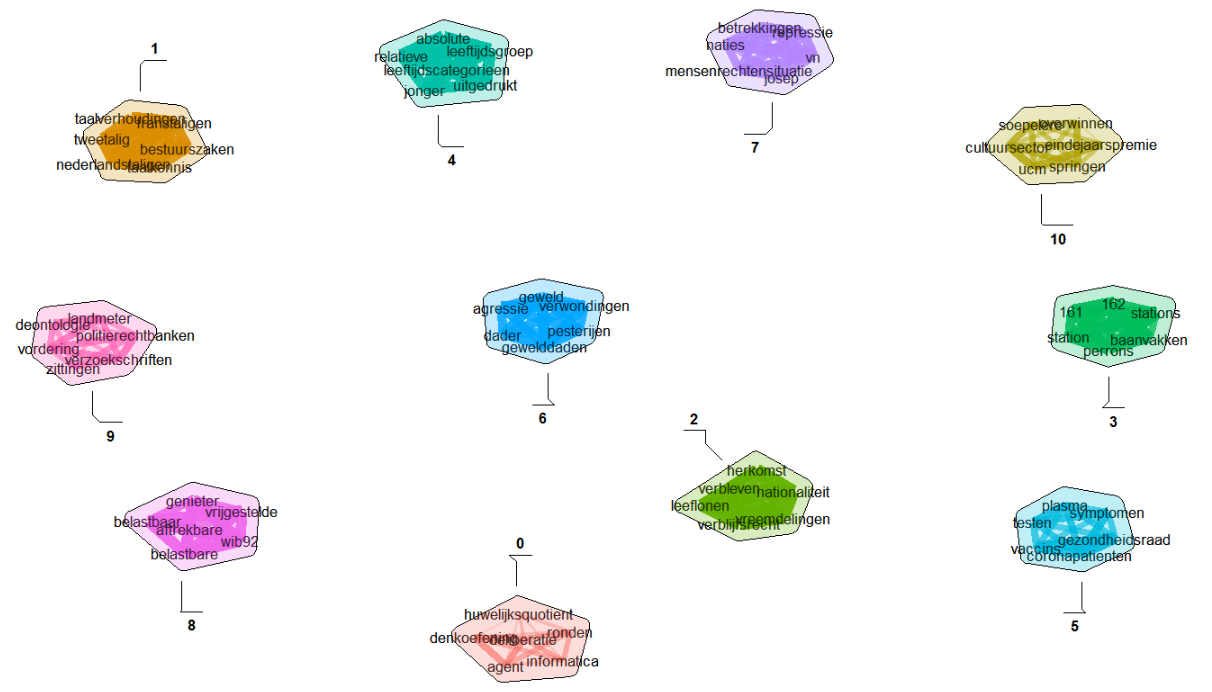

In [37]:
from collections import namedtuple

agg = meta[['id', 'original_title', 'pre_overview']]
TaggedDocument = namedtuple('TaggedDocument', 'words tags')
tagged_train_docs = [TaggedDocument((c), [d]) for d, c in agg[['original_title', 'pre_overview']].values]

In [38]:
len(tagged_train_docs)

44512

In [39]:
tagged_train_docs[:2]

[TaggedDocument(words=' led woody andy toys live happily room andy birthday brings buzz lightyear onto scene afraid losing place andy heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences', tags=['Toy Story']),
 TaggedDocument(words=' siblings judy peter discover enchanted board game opens door magical world unwittingly invite alan adult trapped inside game 26 years living room alan hope freedom finish game proves risky three find running giant rhinoceroses evil monkeys terrifying creatures', tags=['Jumanji'])]

In [40]:
from gensim.models import doc2vec

In [41]:
doc_vectorizer = doc2vec.Doc2Vec(
    dm=0,            # PV-DBOW / default 1
    dbow_words=1,    # w2v simultaneous with DBOW d2v / default 0
    window=10,        # distance between the predicted word and context words
    vector_size=100,        # vector size
    alpha=0.025,     # learning-rate
    seed=1234,
    min_count=5,    # ignore with freq lower
    min_alpha=0.025, # min learning-rate
    workers=4,   # multi cpu
    hs = 1,          # hierar chical softmax / default 0
    negative = 10   # negative sampling / default 5
)

In [42]:
doc_vectorizer.build_vocab(tagged_train_docs)
print(str(doc_vectorizer))

Doc2Vec<dbow+w,d100,n10,hs,w10,mc5,s0.001,t4>


### 모델 학습

In [43]:
# 벡터 문서 학습
from time import time

start = time()

for epoch in tqdm(range(5)):
    doc_vectorizer.train(tagged_train_docs, total_examples=doc_vectorizer.corpus_count, epochs=doc_vectorizer.epochs)
    doc_vectorizer.alpha -= 0.002 # decrease the learning rate
    doc_vectorizer.min_alpha = doc_vectorizer.alpha # fix the learning rate, no decay

#doc_vectorizer.train(tagged_train_docs, total_examples=doc_vectorizer.corpus_count, epochs=doc_vectorizer.epochs)
end = time()

print("During Time: {}".format(end-start))

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## 추천

In [ ]:
doc_vectorizer.docvecs.most_similar('Toy Story', topn=20)